# Exporting Replicated Instance Data for Analytics

This project documents and end-to-end workflow for 

1. querying replicated instance event history from the API
3. Doing some simple visualizations
4. Loading the data into a SQL database
5. Querying it back out for analysis

In [252]:
import json

with open("config.json") as configfile:
    config = json.load(configfile)

REPLICATED_API_TOKEN = config["REPLICATED_API_TOKEN"]
REPLICATED_APP_ID = config["REPLICATED_APP_ID"]

### Fetching an instance

In [253]:
import requests

resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/customer_instances?format=json",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

customers = resp.json()

instance = customers[0]["instances"][1]

instance





{'instanceId': '143421a2-38cf-4cfb-93cc-6f48d0e23bd0',
 'isActive': True,
 'firstReportedAt': '2023-09-15T21:20:47.07Z',
 'lastReportedAt': '2023-10-20T20:27:01.122Z',
 'firstReadyAt': '2023-09-15T21:22:08.461Z',
 'kotsVersion': '1.0.0-beta.8',
 'k8sVersion': 'v1.26.6-gke.1700',
 'isAirgap': False,
 'isKurl': False,
 'lastAppStatus': 'ready',
 'client': 'Replicated-SDK',
 'kurlNodeCountTotal': 0,
 'kurlNodeCountReady': 0,
 'cloudProvider': 'gcp',
 'cloudProviderRegion': 'us-central1',
 'versionLabel': '2.1.0',
 'versionAge': 0,
 'isGitOpsEnabled': False,
 'gitopsProvider': '',
 'isSkipPreflights': None,
 'preflightStatus': None,
 'k8sDistribution': 'gke',
 'customMetricsReportedAt': '2023-10-04T20:50:38.213Z',
 'customMetricsData': {'activeUsers': 8,
  'projectCount': 16,
  'usingCustomRoles': False,
  'usingCustomThemes': True}}

### Fetching events for the instance

In [262]:

resp = requests.get(
    f"https://api.replicated.com/v1/instance/{instance['instanceId']}/events",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

events = resp.json()

# preview one event
events['events'][0]

{'reportedAt': '2023-10-20T18:02:05.413Z',
 'fieldName': 'appStatus',
 'isCustom': False,
 'previousValue': 'degraded',
 'newValue': 'ready',
 '_embedded': None,
 '_resources': {'_self': {'href': '/v1/instance-event/2023-10-20 18:02:05.413 +0000 UTC',
   'method': 'GET',
   'documentation': 'https://replicated-vendor-api.readme.io/v4/reference/getinstanceevent'}}}

### Collecting all AppVersion Events

In [256]:
def clean_filter_events(events, fieldName=None):
    return [
        {k : event[k] for k in {'newValue', 'reportedAt'}} for event in events['events']
        if fieldName is None or event['fieldName'] == fieldName
    ]

appVersionEvents = clean_filter_events(events, 'appVersion')
appVersionEvents

[]

### Exploring for all customer instances

In [121]:
print(f"customers: {len(customers)}")

customers: 4


In [122]:
allInstances = [instance for instance in customer['instances'] for customer in customers]
                        
print(f"instances: {len(allInstances)}")

instances: 12


### Add version label events to a single instance

In [257]:
def add_events(instance, fieldName=None):
    resp = requests.get(
        f"https://api.replicated.com/v1/instance/{instance['instanceId']}/events",
        headers=dict(Authorization=REPLICATED_API_TOKEN),
    )

    events = resp.json()
    instance['events'] = clean_filter_events(events, fieldName)
    return instance

add_events(allInstances[2], 'appVersion')


{'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw',
 'isActive': True,
 'firstReportedAt': '2023-06-28T15:40:17.451Z',
 'lastReportedAt': '2023-10-20T16:32:43.223Z',
 'firstReadyAt': '2023-07-09T17:09:22.418Z',
 'kotsVersion': 'v1.101.1',
 'k8sVersion': 'v1.26.6-gke.1700',
 'isAirgap': False,
 'isKurl': False,
 'lastAppStatus': 'ready',
 'client': 'KOTS',
 'kurlNodeCountTotal': 0,
 'kurlNodeCountReady': 0,
 'cloudProvider': 'gcp',
 'cloudProviderRegion': 'us-central1',
 'versionLabel': '1.14.0',
 'versionAge': 63,
 'isGitOpsEnabled': False,
 'gitopsProvider': '',
 'isSkipPreflights': False,
 'preflightStatus': 'fail',
 'k8sDistribution': 'gke',
 'customMetricsReportedAt': None,
 'customMetricsData': None,
 'events': []}

In [270]:
# invert index from instance->event to event->instance
import datetime

def generate_inverted_events(instances, fieldName=None):
    for instance in instances:
        instance_with_events = add_events(instance, fieldName)
        for event in instance_with_events['events']:
            event['instanceId'] = instance['instanceId']
            event['reportedAt'] = datetime.datetime.strptime(event['reportedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            # event['groupkey'] = f"{event['instanceId']}:{event['newValue']}"
            yield event

import pandas as pd

events = list(generate_inverted_events(allInstances, 'k8sVersion'))
events[:10]

[{'newValue': 'v1.26.6-gke.1700',
  'reportedAt': datetime.datetime(2023, 9, 12, 8, 14, 9, 330000),
  'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw'},
 {'newValue': 'v1.26.5-gke.2700',
  'reportedAt': datetime.datetime(2023, 8, 19, 7, 21, 4, 573000),
  'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw'},
 {'newValue': 'v1.26.5-gke.1400',
  'reportedAt': datetime.datetime(2023, 7, 31, 12, 37, 1, 403000),
  'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw'},
 {'newValue': 'v1.25.10-gke.1400',
  'reportedAt': datetime.datetime(2023, 7, 29, 11, 55, 50, 347000),
  'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw'},
 {'newValue': 'v1.25.10-gke.1200',
  'reportedAt': datetime.datetime(2023, 7, 14, 9, 20, 1, 244000),
  'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw'},
 {'newValue': 'v1.25.9-gke.2300',
  'reportedAt': datetime.datetime(2023, 7, 1, 14, 26, 1, 208000),
  'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw'},
 {'newValue': 'v1.24.12-gke.1000',
  'reportedAt': datetime.datetime(2023, 6, 28, 15, 40, 17, 451000),
  'i

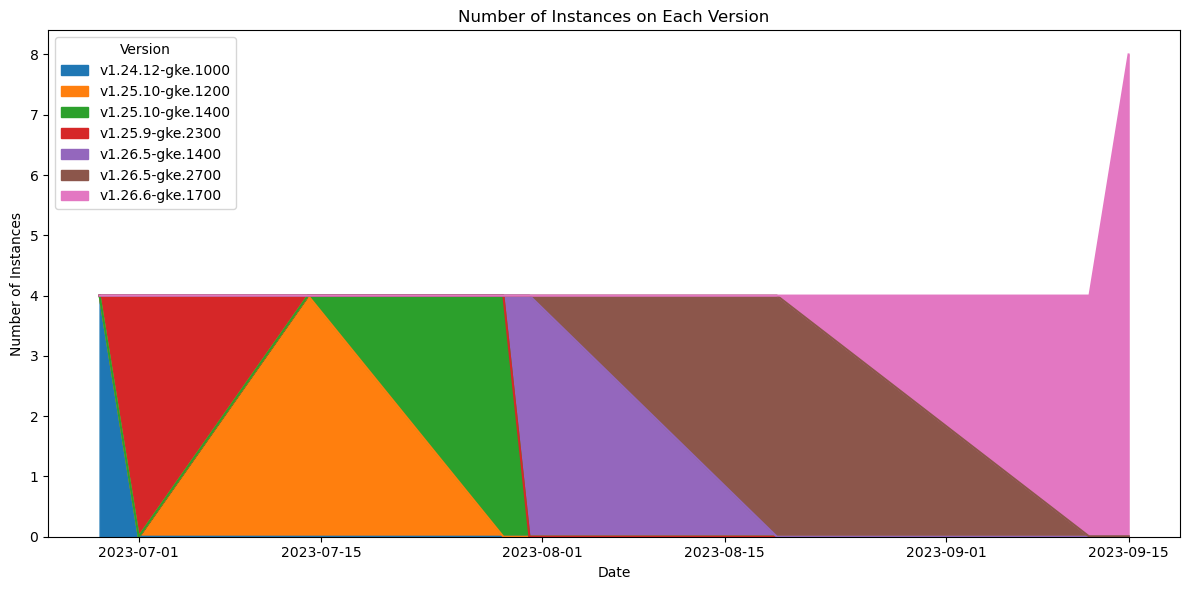

In [271]:
events_df = pd.DataFrame.from_records(events)
df = events_df
df['reportedAt'] = pd.to_datetime(df['reportedAt'])

# Create a date-only column
df['date'] = df['reportedAt'].dt.date

# Create a pivot table
pivot_df = df.pivot_table(index='date', columns='newValue', values='instanceId', aggfunc='count', fill_value=0)

# Plot the result
pivot_df.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Number of Instances on Each Version')
plt.ylabel('Number of Instances')
plt.xlabel('Date')
plt.legend(title='Version', loc='upper left')
plt.tight_layout()
plt.show()

In [354]:
# lets try for app status
events = list(generate_inverted_events(allInstances, 'appStatus'))

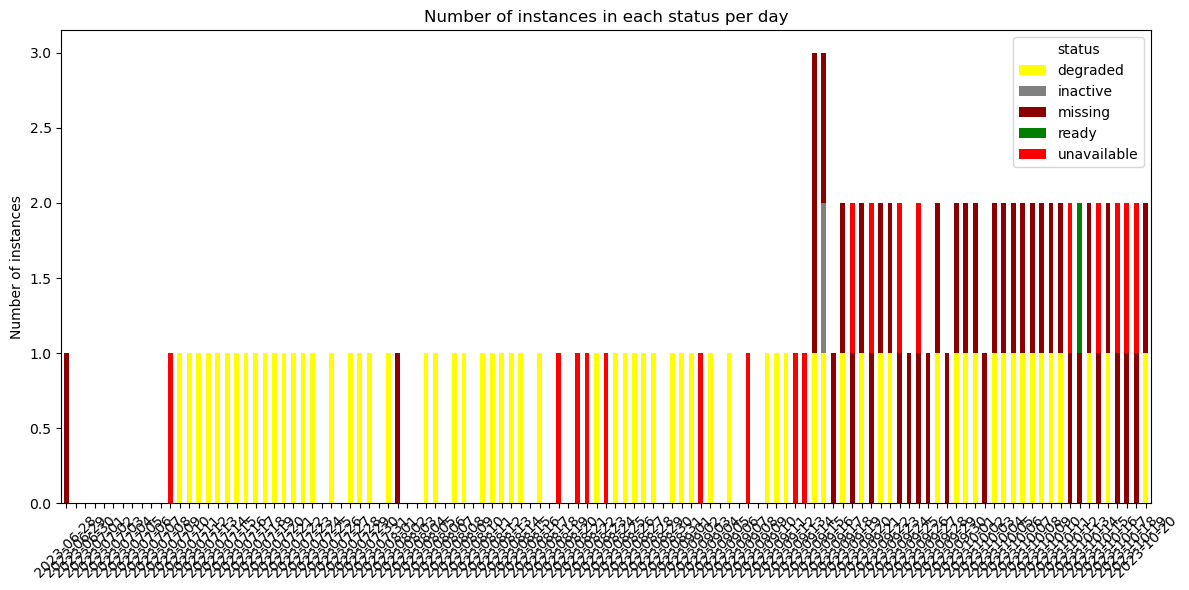

In [283]:
events_df = pd.DataFrame.from_records(events)
df = events_df


# 1. Assign a rank to each status. Higher numbers mean worse status.
status_rank = {
    'ready': 1,
    'updating': 2,
    'degraded': 3,
    'unavailable': 4,
    'missing': 5,
    'inactive': 6
}
df['status_rank'] = df['newValue'].map(status_rank)
df

df['date'] = df['reportedAt'].dt.date
df

worst_status_per_day = df.groupby(['date', 'instanceId'])['status_rank'].max().reset_index()
worst_status_per_day

worst_status_per_day['status'] = worst_status_per_day['status_rank'].map({v: k for k, v in status_rank.items()})
worst_status_per_day

status_counts = worst_status_per_day.groupby(['date', 'status']).size().unstack(fill_value=0)
status_counts

# Define colors for each status
colors = {
    'ready': 'green',
    'updating': 'blue',
    'degraded': 'yellow',
    'unavailable': 'red',
    'missing': 'darkred',
    'inactive': 'grey'
}

import numpy as np

# ... [the rest of the code from before up to the status_counts line]

# Gap-fill missing dates
all_dates = pd.date_range(start=status_counts.index.min(), end=status_counts.index.max())
status_counts = status_counts.reindex(all_dates, fill_value=0)

# Plotting
ax = status_counts.plot(kind='bar', stacked=True, color=[colors[col] for col in status_counts.columns], figsize=(12, 6))
ax.set_ylabel("Number of instances")
ax.set_title("Number of instances in each status per day")
plt.xticks(ticks=np.arange(len(all_dates)), labels=all_dates.strftime('%Y-%m-%d'), rotation=45)
plt.tight_layout()
plt.show()

In [363]:
import pandas as pd

def transform_event_data(data):
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df['rank'] = df['newValue'].map({'ready': 1, 'updating': 2, 'degraded': 3, 'unavailable': 4, 'missing': 5})

    # Pick the worst status for each date-instanceID pair
    worst_idx = df.groupby(['date', 'instanceID'])['rank'].idxmax()
    df = df.loc[worst_idx].drop_duplicates()

    all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max())

    df_expanded = (df.set_index(['date','instanceID'])
                      .reindex(pd.MultiIndex.from_product([all_dates, df['instanceID'].unique()], names=['date','instanceID']))
                      .reset_index())

    df_expanded.sort_values(by=['instanceID','date'], inplace=True)
    df_expanded['newValue'] = df_expanded.groupby('instanceID')['newValue'].ffill()
    df_expanded['rank'] = df_expanded.groupby('instanceID')['rank'].ffill()

    status_count = df_expanded.groupby(['date', 'newValue']).size().unstack(fill_value=0)

    # Rename columns and reorder if needed
    status_count = status_count.reindex(columns=['ready', 'updating', 'degraded', 'unavailable', 'missing'], fill_value=0)

        # Reset the index name
    status_count.index.name = None
    return status_count

test_data = {
    'date': ['2023-10-01', '2023-10-03', '2023-10-03', '2023-10-05', '2023-10-05', '2023-10-07', '2023-10-07', '2023-10-09', '2023-10-09',
             '2023-10-05', '2023-10-07', '2023-10-07', '2023-10-09', '2023-10-09','2023-10-10', '2023-10-10'],
    'newValue': ['ready', 'degraded', 'ready', 'updating', 'missing', 'degraded', 'ready', 'degraded', 'ready',
                 'ready', 'degraded', 'ready', 'degraded', 'ready', 'ready', 'ready'],
    'instanceID': ['instance-1', 'instance-1', 'instance-1', 'instance-1', 'instance-1', 'instance-1', 'instance-1', 'instance-1', 'instance-1',
                   'instance-2', 'instance-2', 'instance-2', 'instance-2', 'instance-2', 'instance-1', 'instance-2']
}

events_df = pd.DataFrame.from_records(events)
events_df['date'] = pd.to_datetime(events_df['reportedAt'])
events_df['instanceID'] = events_df['instanceId']
events_df

# result = transform_event_data(events_df)
# print(result)

# def plot_stacked_bar(df):
#     # Plotting the data as stacked bar chart
#     df.plot(kind='bar', stacked=True, figsize=(12, 8), width=0.8, colormap='viridis')
    
#     # Adding titles and labels
#     plt.title("Status Count Over Time")
#     plt.xlabel("Date")
#     plt.ylabel("Count")
#     plt.grid(axis='y')
#     plt.legend(loc='upper left')
    
#     # Adjusting x-axis to make it more readable
#     plt.xticks(rotation=45)
    
#     # Display the plot
#     plt.tight_layout()
#     plt.show()

# # Call the plot function
# plot_stacked_bar(result)
# #Simple assertion
# pd.testing.assert_frame_equal(result, expected_output)

,newValue,reportedAt,instanceId,date,instanceID
0,ready,2023-10-20 16:32:43.223,2Rq9aF4aVAHozi9JL8CZKkcPvqw,2023-10-20 16:32:43.223,2Rq9aF4aVAHozi9JL8CZKkcPvqw
1,degraded,2023-10-20 16:31:58.683,2Rq9aF4aVAHozi9JL8CZKkcPvqw,2023-10-20 16:31:58.683,2Rq9aF4aVAHozi9JL8CZKkcPvqw
2,ready,2023-10-19 16:23:02.211,2Rq9aF4aVAHozi9JL8CZKkcPvqw,2023-10-19 16:23:02.211,2Rq9aF4aVAHozi9JL8CZKkcPvqw
3,degraded,2023-10-19 16:22:56.227,2Rq9aF4aVAHozi9JL8CZKkcPvqw,2023-10-19 16:22:56.227,2Rq9aF4aVAHozi9JL8CZKkcPvqw
4,unavailable,2023-10-19 16:18:22.880,2Rq9aF4aVAHozi9JL8CZKkcPvqw,2023-10-19 16:18:22.880,2Rq9aF4aVAHozi9JL8CZKkcPvqw
...,...,...,...,...,...
2831,missing,2023-09-15 21:18:56.999,d180c080-30ed-4063-aaae-f018ef73a7f6,2023-09-15 21:18:56.999,d180c080-30ed-4063-aaae-f018ef73a7f6
2832,inactive,2023-09-16 21:19:18.390,d180c080-30ed-4063-aaae-f018ef73a7f6,2023-09-16 21:19:18.390,d180c080-30ed-4063-aaae-f018ef73a7f6
2833,degraded,2023-09-15 21:19:18.390,d180c080-30ed-4063-aaae-f018ef73a7f6,2023-09-15 21:19:18.390,d180c080-30ed-4063-aaae-f018ef73a7f6
2834,unavailable,2023-09-15 21:18:58.342,d180c080-30ed-4063-aaae-f018ef73a7f6,2023-09-15 21:18:58.342,d180c080-30ed-4063-aaae-f018ef73a7f6
